In [17]:
import json
import pygama.lh5 as lh5
from pygama.dsp.WaveformBrowser import WaveformBrowser
import matplotlib.pyplot as plt
import numpy as np
import pygama.analysis.histograms as ph
from scipy.optimize import curve_fit
from functools import reduce
from scipy.signal import find_peaks

from pylab import rcParams
rcParams['figure.figsize'] = 10,5
from pylab import rc
rc("font", size = 14)

home = "/lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/"
f_config = home + "software/meta/com/sipmtest-202110/r2d_config.json"
f_raw = home + "data/com/raw/sipmtest-202110/singles-amaj1-250usec-trace_raw.lh5"
dsp = home +"data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5"
dsp_new = home +"data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5"

def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

def titles(channel):
    if channel == 0:
        plt.title('SiPM 20 (wafer SiPM17W08)', color = 'deeppink')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 1:
        plt.title('SiPM 74 (wafer D02149W13)', color = 'dodgerblue')
        plt.title(r'$\bf{two\ \tau}$', loc = 'right', color = 'blue')
    if channel == 2:
        plt.title('SiPM 15 (wafer SiPM17W06)', color = 'lightcoral')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 3:
        plt.title('SiPM 9 (wafer D02480W05)', color = 'turquoise')
        plt.title(r'$\bf{two\ \tau}$', loc = 'right', color = 'blue')
    if channel == 4:
        plt.title('SiPM 2 (wafer SiPM17W08)', color = 'deeppink')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 5:
        plt.title('SiPM 26 (wafer SiPM17W08)', color = 'deeppink')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 6:
        plt.title('SiPM 19 (wafer SiPM17W08)', color = 'deeppink')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 7:
        plt.title('SiPM 73 (wafer D02149W13)', color = 'dodgerblue')
        plt.title(r'$\bf{two\ \tau}$', loc = 'right', color = 'blue')
    if channel == 8:
        plt.title('SiPM 33 (wafer SiPM17W06)', color = 'lightcoral')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 9:
        plt.title('SiPM 7 (wafer D02480W05)', color = 'turquoise')
        plt.title(r'$\bf{two\ \tau}$', loc = 'right', color = 'blue')
    if channel == 10:
        plt.title('SiPM 3 (wafer SiPM17W08)', color = 'deeppink')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 11:
        plt.title('SiPM 25 (wafer SiPM17W08)', color = 'deeppink')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 13:
        plt.title('SiPM 29 (wafer SiPM17W07)', color = 'limegreen')
        plt.title(r'$\bf{2nd\ long\ \tau}$', loc = 'right', color = 'green')
    if channel == 14:
        plt.title('SiPM 50 (wafer SiPM17W06)', color = 'lightcoral')
        plt.title(r'$\bf{one\ \tau}$', loc = 'right', color = 'red')
    if channel == 15:
        plt.title('SiPM 49 (wafer SiPM17W05)', color = 'olivedrab')
        plt.title(r'$\bf{2nd\ long\ \tau}$', loc = 'right', color = 'green')

def browsing(chn):
    # ch selection
    ch = lh5.load_nda(dsp_new, ['channel'], 'spms/dsp')['channel']
    ch_selection = (ch==chn)

    # only one peak in derivative of wf
    maxes_der = lh5.load_nda(dsp, ['vt_max_out'], 'spms/dsp')['vt_max_out']
    cts_der = (np.isnan(maxes_der) == False).sum(axis = 1)
    ev_sel_der = (cts_der == 1)

    # only one peak in wf
    maxes_wf = lh5.load_nda(dsp, ['max_wf'], 'spms/dsp')['max_wf']
    cts_wf = (np.isnan(maxes_wf) == False).sum(axis = 1)
    ev_sel_maxes = (cts_wf == 1)

    # slope of baseline ~ 0
    bl_slope = lh5.load_nda(dsp, ['bl_slope'], 'spms/dsp')['bl_slope']
    bl_slope_ch = bl_slope[ch == chn]

    plt.figure(figsize=(12,6))
    plt.xlabel("ADC/$\mu$s", ha='right', x=1)
    plt.ylabel("Number of events", ha='right', y=1)
    n, b, patches = ph.get_hist(bl_slope_ch, bins = np.linspace(-0.03,0.03,150))
    bin_max = b[np.where(n == n.max())][0]
    height_max = n[np.where(b == bin_max)][0]

    bin_heights, bin_borders,_ = plt.hist(bl_slope_ch, bins = np.linspace(-0.03,0.03,150))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders)/2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[height_max, bin_max, 0.01])
    gauss_ampl = popt[0]
    gauss_mean = popt[1]
    gauss_sigma = popt[2]
    interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    plt.plot(interval_for_fit, gaussian(interval_for_fit, *popt),label=f'fit: $\mu$={gauss_mean:.4f}, $\sigma$={gauss_sigma:.4f}',color='red')
    l_slope_cut = gauss_mean - 1.5*gauss_sigma
    r_slope_cut = gauss_mean + 1.5*gauss_sigma
    plt.axvline(l_slope_cut, color='green', linestyle=':', label = f'$\mu$ - 1.5$\sigma$ = {l_slope_cut:.5f}')
    plt.axvline(r_slope_cut, color='red', linestyle=':', label = f'$\mu$ + 1.5$\sigma$ = {r_slope_cut:.5f}')
    plt.title(f"Slope histogram - ch {chn}")

    flat_bl_sel = (bl_slope < r_slope_cut) & (bl_slope > l_slope_cut)

    #neg wf end cut
    endpoint = lh5.load_nda(dsp, ['bl_mean_end'],'spms/dsp')['bl_mean_end']
    bl_std = lh5.load_nda(dsp, ['bl_std'], 'spms/dsp')['bl_std']
    neg_cut = (endpoint > -bl_std)

    #t0 cut
    t0_accept = (ch == chn) & (cts_wf == 1)
    t0 = lh5.load_nda(dsp_new, ['t0'], 'spms/dsp')['t0']

    plt.figure(figsize=(12,6))
    plt.xlabel("$\mu$s", ha='right', x=1)
    plt.ylabel("Number of events", ha='right', y=1)
    n, b, patches = ph.get_hist(t0[t0_accept]*0.016, bins = np.linspace(0,30,150))
    bin_max = b[np.where(n == n.max())][0]
    height_max = n[np.where(b == bin_max)][0]

    bin_heights, bin_borders,_ = plt.hist(t0[t0_accept]*0.016, bins = np.linspace(0,30,150))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders)/2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[height_max, bin_max, 1])
    gauss_ampl = popt[0]
    gauss_mean = popt[1]
    gauss_sigma = popt[2]
    interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    plt.plot(interval_for_fit, gaussian(interval_for_fit, *popt),label=f'fit: $\mu$={gauss_mean:.4f}, $\sigma$={gauss_sigma:.4f}',color='red')
    l_t0_cut = gauss_mean - 2*gauss_sigma
    r_t0_cut = gauss_mean + 2*gauss_sigma
    plt.axvline(l_t0_cut, color='green', linestyle=':', label = f'$\mu$ - 1.5$\sigma$ = {l_t0_cut:.5f}')
    plt.axvline(r_t0_cut, color='red', linestyle=':', label = f'$\mu$ + 1.5$\sigma$ = {r_t0_cut:.5f}')
    plt.xlim(0,15)
    plt.title(f"t0 histogram - ch {chn}")

    t0_cut = (t0*0.016 > l_t0_cut) & (t0*0.016 < r_t0_cut)

    accept = ch_selection & ev_sel_der & flat_bl_sel & ev_sel_maxes & t0_cut

    with open(f_config) as f:
        dsp_cfg = json.load(f)['dsp_config']

    browser = WaveformBrowser(f_raw, '/spms/raw', dsp_cfg,
                              waveforms=['wf_blsub'],
                              selection = accept,
                              #lines=['t0', 'bl_std'],
                              n_drawn= 10
                              )

    for entries, i in zip(browser, range(30)):
        titles(chn)
        plt.title(f'ch {chn}', loc = 'left')
        plt.xlim(0,20000)
        plt.show()

def pe_spectrum_area(channel):
    area = lh5.load_nda(dsp, ['sum_wf'],'spms/dsp')['sum_wf']
    ch = lh5.load_nda(dsp_new, ['channel'], 'spms/dsp')['channel']
    number_wfs_ch = len(np.where(ch == channel)[0])
    energy = area[ch == channel]
    bins = np.linspace(-5000, 50000, 500)
    plt.hist(energy, bins = bins, label = 'Area under waveform (0-30us)')
    plt.xlim(-5000,50000)
    #plt.ylim(0,1200)
    plt.xlabel('ADC')
    plt.ylabel('Number of events')
    plt.legend()
    plt.title('channel '+str(channel)+' ('+str(number_wfs_ch)+' waveforms)')
    plt.show()

def cuts(channel):
    df = lh5.load_nda(dsp, ['bl_mean', 'bl_std','bl_slope', 'max_wf', 'vt_max_out', 
                                 't0', 'bl_mean_end'],'spms/dsp')
    bl_mean = df['bl_mean']
    bl_std = df['bl_std']
    bl_slope = df['bl_slope']
    maxes_wf = df['max_wf']
    max_der = df['vt_max_out']
    endpoint = df['bl_mean_end']
    ch = lh5.load_nda(dsp_new, ['channel'], 'spms/dsp')['channel']
    t0 = lh5.load_nda(dsp_new, ['t0'], 'spms/dsp')['t0']

    #channel selection
    ch_selection = (ch == channel)

    # only one peak in wf
    cts_wf = (np.isnan(maxes_wf) == False).sum(axis = 1)

    # only one peak in derivative of wf
    cts_der = (np.isnan(max_der) == False).sum(axis = 1)

    # slope of baseline ~ 0
    bl_slope_ch = bl_slope[ch == channel]

    n, b, patches = ph.get_hist(bl_slope_ch, bins = np.linspace(-0.03,0.03,150))
    bin_max = b[np.where(n == n.max())][0]
    height_max = n[np.where(b == bin_max)][0]

    bin_heights, bin_borders = np.histogram(bl_slope_ch, bins = np.linspace(-0.03,0.03,150))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders)/2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[height_max, bin_max, 0.01])
    gauss_ampl = popt[0]
    gauss_mean = popt[1]
    gauss_sigma = popt[2]
    interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    l_slope_cut = gauss_mean - 1.5*gauss_sigma
    r_slope_cut = gauss_mean + 1.5*gauss_sigma

    flat_bl_sel = (bl_slope < r_slope_cut) & (bl_slope > l_slope_cut)
    
    # neg baseline @ the end of wf cut
    neg_cut = (endpoint > -bl_std)

    #t0 cut
    t0_accept = (ch == channel) & (cts_wf == 1)

    n, b, patches = ph.get_hist(t0[t0_accept]*0.016, bins = np.linspace(0,30,150))
    bin_max = b[np.where(n == n.max())][0]
    height_max = n[np.where(b == bin_max)][0]

    bin_heights, bin_borders = np.histogram(t0[t0_accept]*0.016, bins = np.linspace(0,30,150))
    bin_centers = bin_borders[:-1] + np.diff(bin_borders)/2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[height_max, bin_max, 1])
    gauss_ampl = popt[0]
    gauss_mean = popt[1]
    gauss_sigma = popt[2]
    interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    l_t0_cut = gauss_mean - 2*gauss_sigma
    r_t0_cut = gauss_mean + 2*gauss_sigma
    
    t0_cut = (t0*0.016 > l_t0_cut) & (t0*0.016 < r_t0_cut)

    return ch_selection, cts_wf, cts_der, flat_bl_sel, neg_cut, t0_cut, r_t0_cut

def pe_spectrum_area_cuts(channel):
    df = lh5.load_nda(dsp, ['sum_wf'],'spms/dsp')
    area = df['sum_wf']
    
    ch_selection, cts_wf, cts_der, flat_bl_sel, neg_cut, t0_cut, r_t0_cut = cuts(channel)

    number_wfs_ch = len(np.where(ch_selection == True)[0])
    energy = area[ch_selection]
    bins = np.linspace(-5000,100000, 300)
    
    plt.subplots(tight_layout=True, figsize=(8, 6))
    plt.hist(energy, bins = bins, label = 'no cut')

    cts_wf_new = cts_wf[ch_selection]
    energy_cut1 = energy[cts_wf_new == 1]
    plt.hist(energy_cut1, bins = bins, label = ('wf peak cut ('+str(len(energy_cut1))+' wfs)'), color = 'orange')

    cts_der = cts_der[ch_selection][cts_wf_new == 1]
    energy_cut2 = energy_cut1[cts_der == 1]
    plt.hist(energy_cut2, bins =bins, label = ('deriv peak cut ('+str(len(energy_cut2))+' wfs)'), color = 'green')

    flat_bl_sel = flat_bl_sel[ch_selection][cts_wf_new == 1][cts_der == 1]
    energy_cut3 = energy_cut2[flat_bl_sel]
    plt.hist(energy_cut3, bins = bins, label = ('slope cut ('+str(len(energy_cut3))+' wfs)'), color = 'black')

    neg_cut = neg_cut[ch_selection][cts_wf_new == 1][cts_der == 1][flat_bl_sel]
    energy_cut4 = energy_cut3[neg_cut]
    plt.hist(energy_cut4, bins = bins, label = ('neg end cut ('+str(len(energy_cut4))+' wfs)'), color = 'yellow')

    t0_cut = t0_cut[ch_selection][cts_wf_new == 1][cts_der == 1][flat_bl_sel][neg_cut]
    energy_cut5 = energy_cut4[t0_cut]
    plt.hist(energy_cut5, bins = bins, label = ('t0 cut ('+str(len(energy_cut5))+' wfs)'), color = 'red')

    #hist, bin_edges = np.histogram(energy, bins = 2000)
    #peaks, props = find_peaks(hist, height= 1000)
    print('Number of accepted wfs: '+str(len(energy_cut5)))
    plt.xlim(-5000,100000)
    #plt.ylim(0,4000)
    plt.yscale('log')
    plt.ylim(0.5, 10000)
    plt.xlabel('ADC')
    plt.ylabel('Number of events')
    plt.legend()
    plt.title('channel '+str(channel)+' ('+str(number_wfs_ch)+' waveforms)')
    plt.show()
    
def get_pileup_rate(channel):
    area = lh5.load_nda(dsp_new, ['area_25us'],'spms/dsp')['area_25us']
    df = lh5.load_nda(dsp, ['max_wf', 'vt_max_out'],'spms/dsp')
    maxes_wf = df['max_wf']
    max_der = df['vt_max_out']
    ch = lh5.load_nda(dsp_new, ['channel'], 'spms/dsp')['channel']
    
    plt.subplots(tight_layout=True)
    bins = np.linspace(-5000,100000, 300)
    
    #channel selection
    ch_indices = np.where(ch == channel)[0]
    area_ch = area[ch_indices]
    number_wfs_ch = len(ch_indices)
    plt.hist(area_ch, bins = bins, label = f'no cut ({number_wfs_ch}) wfs')
    
    cts_wf = (np.isnan(maxes_wf) == False).sum(axis = 1)
    cts_wf = cts_wf[ch_indices]
    
    #signal events i.e. >= 1 peak
    signal_indices = np.where(cts_wf >0)[0]
    area_cut_signal = area_ch[signal_indices]
    number_signal_evts = len(area_cut_signal)
    plt.hist(area_cut_signal, bins = bins, label = f'signal events ({number_signal_evts}) wfs')
    
    # only one peak in wf
    cts_wf = cts_wf[signal_indices]
    one_peak_indices = np.where(cts_wf == 1)[0]
    area_cut_pileup1 = area_cut_signal[one_peak_indices]
    
    # only one peak in derivative of wf
    cts_der = (np.isnan(max_der) == False).sum(axis = 1)
    cts_der = cts_der[ch_indices][signal_indices][one_peak_indices]
    one_peak_der_indices = np.where(cts_der == 1)[0]
    area_cut_pileup2 = area_cut_pileup1[one_peak_der_indices]
    number_nopileup = len(area_cut_pileup2)
    plt.hist(area_cut_pileup2, bins = bins, label = f'after pile-up cut ({number_nopileup}) wfs')
    
    pileup_ratio = number_nopileup/number_signal_evts*100
    print(f'{pileup_ratio:.2f} % pile-up events')
    plt.xlim(-5000,100000)
    plt.yscale('log')
    plt.ylim(0.5, 10000)
    plt.xlabel('ADC')
    plt.ylabel('Number of events')
    plt.legend()
    titles(channel)
    plt.title(f'ch {channel}', loc = 'left')
    plt.show()

def pe_selection(channel, width, prominence, plot=True):
    df = lh5.load_nda(dsp, ['sum_wf'],'spms/dsp')
    area = df['sum_wf']

    ch_selection, cts_wf, cts_der, flat_bl_sel, neg_cut, t0_cut, r_t0_cut = cuts(channel)
    ev_sel_der = (cts_der == 1)
    ev_sel_maxes = (cts_wf == 1)
    
    accept = ch_selection & ev_sel_maxes & ev_sel_der & flat_bl_sel & neg_cut & t0_cut
    energy = area[accept]
    bins = np.linspace(0,100000, 500)
    hist, bin_edges = np.histogram(energy, bins = bins)
    peaks, props = find_peaks(hist, height= 100, width = width, prominence = prominence)
    if plot==True:
        plt.hist(energy, bins = bins, label =f'area (0-30 us) (prom = {prominence}, width = {width})')
        plt.plot(bin_edges[peaks], hist[peaks], 'x', color = 'red')
        plt.xlim(0,bin_edges[peaks[0]]*5)
        plt.ylim(0,hist[peaks[0]]*1.3)
        plt.vlines(1.1*bin_edges[peaks[0]], 0, 1000, color = 'green', linestyle=':', label = 'low energy cut (<1.1 PE) ')
        plt.vlines(2.5*bin_edges[peaks[0]], 0, 1000, color = 'red', linestyle=':', label = 'high energy cut (>2.5 PE)')
        plt.xlabel('ADC')
        plt.ylabel('Number of events')
        plt.title(f"Area histogram - ch {channel} ({len(energy)} selected events) ")
        plt.legend()
        plt.show()
    else:
        return bin_edges[peaks[0]]
    
    
def superpulse(channel, energy_cut, width, prominence): #if energy_cut == 0 -> no energy cut, 
                                                         #   energy_cut == 1 -> low energy cut,
                                                         #   energy_cut == 2 -> high energy cut
    st = lh5.Store()
    number_wfs = st.read_n_rows('spms/raw/waveform/values', f_raw)
    print('Number of all waveforms: '+str(number_wfs))  

    ch_selection, cts_wf, cts_der, flat_bl_sel, neg_cut, t0_cut, r_t0_cut = cuts(channel)
    
    ch_indices = np.where(ch_selection)[0]
    number_wfs_ch = len(ch_indices)
    print('Number of waveforms in channel '+str(channel)+': '+str(number_wfs_ch))

    ev_sel_der = (cts_der == 1)
    max_der_indices = np.where(ev_sel_der)[0]

    ev_sel_maxes = (cts_wf == 1)
    max_wf_indices = np.where(ev_sel_maxes)[0]

    bl_slope_indices = np.where(flat_bl_sel)[0]

    endpoint_indices = np.where(neg_cut)[0]

    t0_indices = np.where(t0_cut)[0]
    
    if energy_cut == 0:
        accept_indices = reduce(np.intersect1d, (ch_indices, max_der_indices, max_wf_indices, 
                            bl_slope_indices, endpoint_indices, t0_indices))

    if energy_cut == 1:
        peak_spe = pe_selection(channel, width , prominence,False)
        area = lh5.load_nda(dsp, ['sum_wf'], 'spms/dsp')['sum_wf']
        area_cut = area < 1.1*peak_spe
        area_indices = np.where(area_cut)[0]
        accept_indices = reduce(np.intersect1d, (ch_indices, max_der_indices, max_wf_indices, 
                            bl_slope_indices, endpoint_indices, t0_indices, area_indices))
    
    if energy_cut == 2:
        peak_spe = pe_selection(channel, width , prominence, False)
        area = lh5.load_nda(dsp, ['sum_wf'], 'spms/dsp')['sum_wf']
        area_cut = area > 2.5*peak_spe
        area_indices = np.where(area_cut)[0]
        accept_indices = reduce(np.intersect1d, (ch_indices, max_der_indices, max_wf_indices, 
                            bl_slope_indices, endpoint_indices, t0_indices, area_indices))

    wf_cuts = lh5.load_nda(f_raw, ['values'], 'spms/raw/waveform', idx_list = accept_indices)['values'][:,0:1900]
    wf_cuts = np.asarray(wf_cuts, dtype = np.float32)
    
    bl_mean = lh5.load_nda(dsp, ['bl_mean', 't0'],'spms/dsp')['bl_mean']
    t0 = lh5.load_nda(dsp_new, ['t0'],'spms/dsp')['t0']
    
    for i in range(len(wf_cuts)):
        wf_cuts[i] = wf_cuts[i] - bl_mean[accept_indices][i]
    print('Number of selected waveforms: '+str(len(wf_cuts)))

    # shift wfs to the same t0 ~ 5us --> index 312
    t0_int = np.asarray(t0, dtype = np.int16)[accept_indices]
    for i in range(len(t0_int)):
        wf_cuts[i] = np.roll(wf_cuts[i], 312-t0_int[i], axis = 0)
    wf_cuts = wf_cuts[:,(int(r_t0_cut/0.016)-312):]   # delete values which were shifted to the start of the waveform
    
    superpulse = np.sum(wf_cuts, axis = 0)/len(wf_cuts)
    t = np.arange(0, len(superpulse)*0.016, 0.016)
    percentage = np.around(len(wf_cuts)/number_wfs_ch*100,2)
    number_selected_wfs = len(wf_cuts)
    return(t, superpulse, percentage, number_selected_wfs)

def exp(t,a,tau):
    return a*np.exp(- t/tau)

def fit_exp_withoutenergycut(channel, width, prominence):
    t, y, percentage, number_selected_wfs = superpulse(channel, 0, width , prominence)     #t in us
    popt, pcov = curve_fit(exp, t[300:1700] , y[300:1700])
    tau = popt[1]
    perr = np.sqrt(np.diag(pcov))
    delta_tau = perr[1]
    
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))
    plt.title(f'Super pulse - channel {channel} ({percentage} % selected, {number_selected_wfs} wfs) ')
    ax.plot(t[0:1700], y[0:1700])
    ax.plot(t[300:1700], exp(t[300:1700], popt[0], tau), label = ('tau = '+str(np.around(tau, 2))+'+-'+str(np.around(delta_tau, 2))+' us'), color = 'red', linestyle='dashed')
    ax.set_xlabel('us')
    ax.set_ylabel('ADC')
    ax.legend()
    plt.show()

def fit_exp(channel, width , prominence):
    t, y, percentage, number_selected_wfs = superpulse(channel, 1, width , prominence)     #t in us
    t_high, y_high, percentage_high, number_selected_wfs_high = superpulse(channel, 2, width , prominence)
    popt, pcov = curve_fit(exp, t[300:1700] , y[300:1700])
    popt_high, pcov_high = curve_fit(exp, t_high[300:1700] , y_high[300:1700])
    tau = popt[1]
    tau_high = popt_high[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))
    fig.suptitle(f'channel {channel}')
    
    ax1.plot(t[0:1700], y[0:1700])
    ax1.plot(t[300:1700], exp(t[300:1700], popt[0], tau), label = ('tau = '+str(np.around(tau, 2))+' us'), color = 'red', linestyle='dashed')
    ax1.set_xlabel('us')
    ax1.set_ylabel('ADC')
    ax1.set_title(f'Super pulse "low energy" ({percentage} % selected, {number_selected_wfs} wfs) ')
    ax1.legend()

    ax2.plot(t_high[0:1700], y_high[0:1700])
    ax2.plot(t_high[300:1700], exp(t_high[300:1700], popt_high[0], tau_high), label = ('tau = '+str(np.around(tau_high, 2))+' us'), color = 'red', linestyle='dashed')
    ax2.set_xlabel('us')
    ax2.set_ylabel('ADC')
    ax2.set_title(f'Super pulse "high energy" ({percentage_high} % selected, {number_selected_wfs_high} wfs) ')
    ax2.legend()
    plt.show()
    
def fit_exp_oneplot(channel, width , prominence, savefile=""):
    t, y, percentage, number_selected_wfs = superpulse(channel, 1, width , prominence)     #t in us
    if(savefile != ""):
        with open(savefile, 'wb') as f:
            np.save(f,t)
            np.save(f,y)
    t_high, y_high, percentage_high, number_selected_wfs_high = superpulse(channel, 2, width , prominence)
    popt, pcov = curve_fit(exp, t[300:1700] , y[300:1700])
    popt_high, pcov_high = curve_fit(exp, t_high[300:1700] , y_high[300:1700])
    tau = popt[1]
    tau_high = popt_high[1]
    
    plt.subplots(tight_layout=True)
    plt.title(f'ch {channel}', loc = 'left')
    titles(channel)
    plt.xlabel(r'$\mu$s')
    plt.ylabel('ADC')
    
    plt.plot(t[0:1700], y[0:1700], label = f'"low energy" ({percentage} % selected, {number_selected_wfs} wfs)')
    plt.plot(t[300:1700], exp(t[300:1700], popt[0], tau), label = (r'$\tau_{low}$ = '+str(np.around(tau, 2))+r'$\mu$s'), color = 'red', linestyle='dashed')
    plt.plot(t_high[0:1700], y_high[0:1700], label = f'"high energy" ({percentage_high} % selected, {number_selected_wfs_high} wfs)', color = 'limegreen')
    plt.plot(t_high[300:1700], exp(t_high[300:1700], popt_high[0], tau_high), label = (r'$\tau_{high}$ = '+str(np.around(tau_high, 2))+r'$\mu$s'), color = 'black', linestyle='dashed')
    plt.legend()
    plt.show()
    
def fit_exp_category3(channel, width , prominence,savefile=''):
    t, y, percentage, number_selected_wfs = superpulse(channel, 1, width , prominence)     #t in us
    t_high, y_high, percentage_high, number_selected_wfs_high = superpulse(channel, 2, width , prominence)
    if(savefile != ""):
        with open(savefile, 'wb') as f:
            np.save(f,t)
            np.save(f,y)
    
    popt, pcov = curve_fit(exp, t[360:1700] , y[360:1700])
    popt_high, pcov_high = curve_fit(exp, t_high[360:1700] , y_high[360:1700])
    popt_short, pcov_short = curve_fit(exp, t[295:360] , y[295:360])
    popt_high_short, pcov_high_short = curve_fit(exp, t_high[295:360] , y_high[295:360])
    
    tau = popt[1]
    tau_high = popt_high[1]
    tau_short = popt_short[1]
    tau_high_short = popt_high_short[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 6))
    fig.suptitle(f'channel {channel}')
    
    ax1.plot(t[0:1700], y[0:1700])
    ax1.plot(t[360:1700], exp(t[360:1700], popt[0], tau), label = ('tau = '+str(np.around(tau, 2))+' us'), color = 'red', linestyle='dashed') 
    ax1.plot(t[295:360], exp(t[295:360], popt_short[0], tau_short), label = ('tau = '+str(np.around(tau_short, 2))+' us'), color = 'green', linestyle='dashed')
    ax1.set_xlabel('us')
    ax1.set_ylabel('ADC')
    ax1.set_title(f'Super pulse "low energy" ({percentage} % selected, {number_selected_wfs} wfs) ')
    ax1.legend()

    ax2.plot(t_high[0:1700], y_high[0:1700])
    ax2.plot(t_high[360:1700], exp(t_high[360:1700], popt_high[0], tau_high), label = ('tau = '+str(np.around(tau_high, 2))+' us'), color = 'red', linestyle='dashed')
    ax2.plot(t_high[295:360], exp(t_high[295:360], popt_high_short[0], tau_high_short), label = ('tau = '+str(np.around(tau_high_short, 2))+' us'), color = 'green', linestyle='dashed')
    ax2.set_xlabel('us')
    ax2.set_ylabel('ADC')
    ax2.set_title(f'Super pulse "high energy" ({percentage_high} % selected, {number_selected_wfs_high} wfs) ')
    ax2.legend()
    plt.show()

In [ ]:
for i in [0,1,2,3,4,5,6,7,8,9,10,11,13,14,15]:
    browsing(i)

In [ ]:
for i in [0,1,2,3,4,5,6,8,9,10,11,13,14,15]:
    pe_selection(i,2, 200, True)

In [ ]:
for i in [0,1,2,3,4,5,6,8,9,10,11,14]:
    fit_exp(i, 2, 200)
    pe_spectrum_area_cuts(i)

In [ ]:
for i in [13,15]:
    fit_exp_category3(i, 2, 200)
    pe_spectrum_area_cuts(i)

In [ ]:
for i in [0,1,2,3,4,5,6,8,9,10,11,14]:
    fit_exp_oneplot(i, 2 , 200)

In [ ]:
browsing(9)

In [ ]:
browsing(14)

loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
78.25 % pile-up events


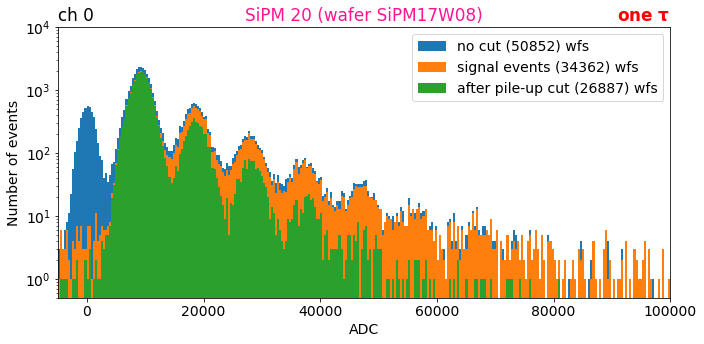

In [9]:
cts_wf = get_pileup_rate(0)

loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
59.16 % pile-up events


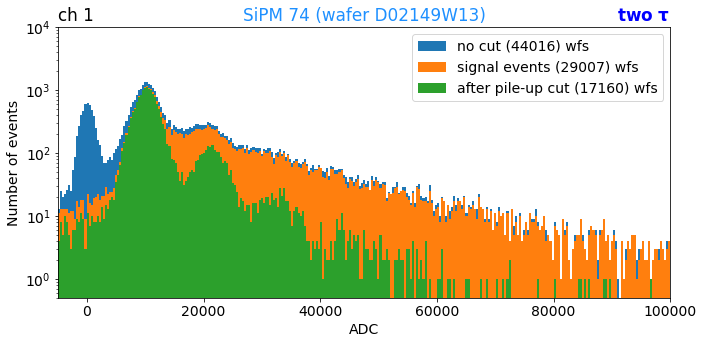

In [10]:
cts_wf = get_pileup_rate(1)

loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
69.10 % pile-up events


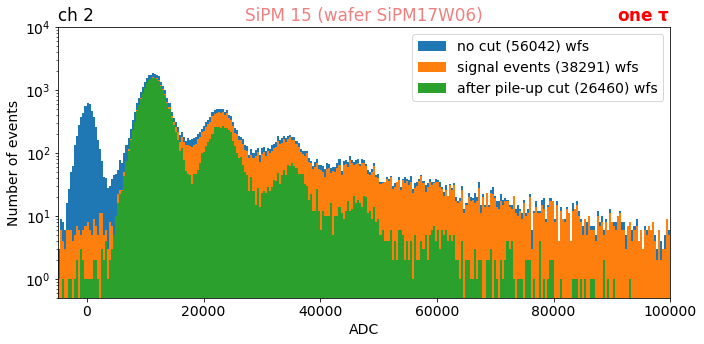

In [11]:
cts_wf = get_pileup_rate(2)

loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
68.83 % pile-up events


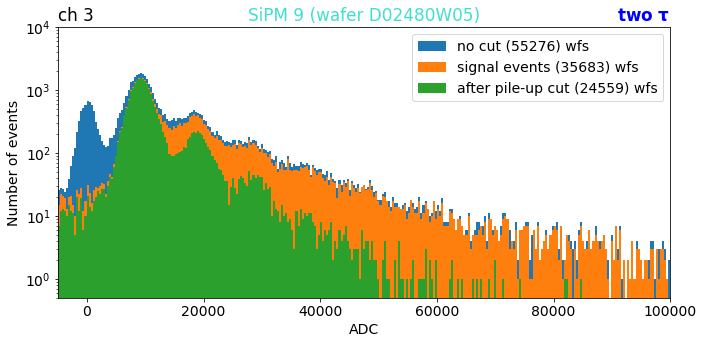

In [12]:
cts_wf = get_pileup_rate(3)

In [ ]:
cts_wf = get_pileup_rate(4)

In [ ]:
for i in [0,1,2,3,4,5,6,8,9,10,11,13,14,15]:
   superpulse(i,1, 0,200)

Number of all waveforms: 11965002
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
Number of waveforms in channel 0: 50852
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l

Number of all waveforms: 11965002
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
Number of waveforms in channel 0: 50852
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l

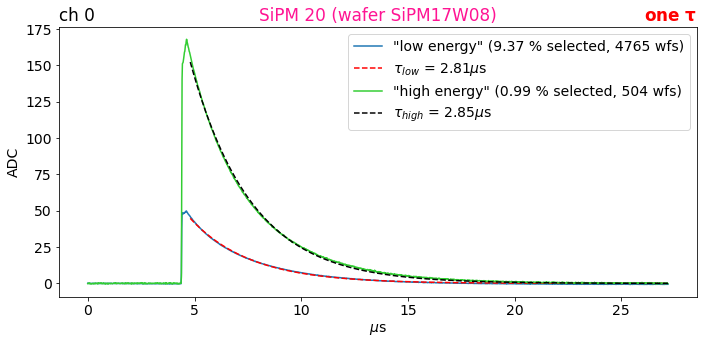

In [12]:
fit_exp_oneplot(0, 0 , 0, 'ch0.npy')

Number of all waveforms: 11965002
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
Number of waveforms in channel 13: 69871
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp-v1.lh5
loading data for /lfs/l1/legend/users/rdeckert/pygama/experiments/lar_commissioning/data/com/dsp/sipmtest-202110/singles-amaj1-250usec-trace_dsp.lh5
loading data for /lfs/

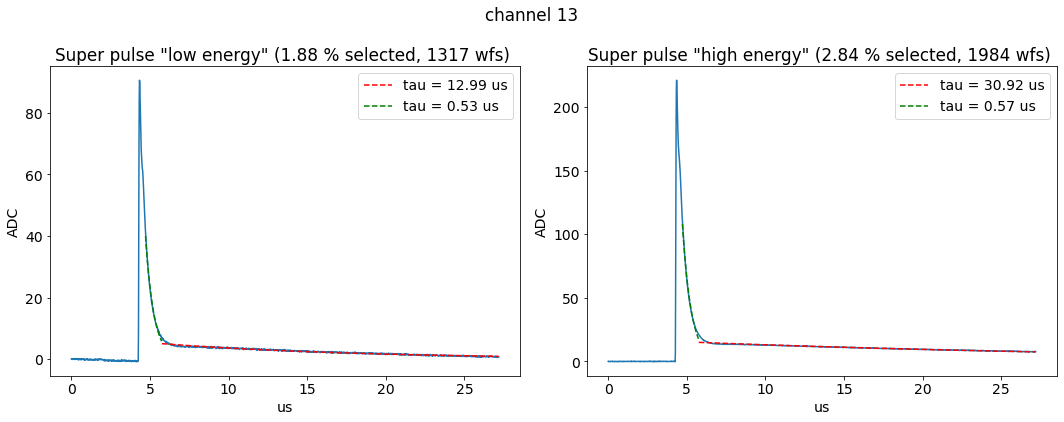

In [18]:
fit_exp_category3(13, 0 , 0, 'ch13.npy')